# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=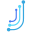)](https://jvelezmagic.com/)

![Curso de Manejo de Datos Faltantes: Exploración](course-logo.jpg)

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
from scipy import stats as stats
import seaborn as sns
import session_info
import sklearn as sklearn
import sklearn.compose as compose
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [2]:
#Incorpora en el codigo las funcionesque provienen de otro archivo
%run pandas_missing_extension.py

/home/cristian/Escritorio/curso-datos-faltantes-imputacion-main/imputacion_valores_faltantes/lib/python3.10/site-packages/upsetplot/plotting.py:20: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


## Configurar el aspecto general de las gráficas del proyecto

In [11]:
%matplotlib inline #los graficos seran bajo la linea de codigo que los invoca

sns.set(
    rc={
        #parametro de tamaño de la figura
        "figure.figsize": (8, 6)
    }
)
#Tema de colores del grafico
sns.set_style("whitegrid")

UsageError: unrecognized arguments: #los graficos seran bajo la linea de codigo que los invoca


## El problema de trabajar con valores faltantes

Aveces los algoritmos de regrecion lineal entre otros saltean los valores faltantes en su ejecucion, por eso hay que considerar la cantidad de registros que se toman por cada analisis de regresion y los que se ignoran, para en cao de que se esten ingorando muchos regitros realizar modelos de regresion personalizados.

In [10]:
# Obtener el conjunto de datos "airquality"
airquality_df = (
    sm.datasets.get_rdataset("airquality")  # Obtener el conjunto de datos "airquality"
    .data  # Acceder a los datos del conjunto de datos obtenido
    .clean_names(case_type="snake")  # Convertir los nombres de las columnas a snake_case
    .add_column("year", 1973)  # Agregar una columna "year" con el valor constante de 1973
    .assign(date=lambda df: pd.to_datetime(df[["year", "month", "day"]]))  # Agregar una columna "date" combinando las columnas "year", "month" y "day" como objetos de fecha y hora
    .sort_values(by="date")  # Ordenar los datos por la columna "date"
    .set_index("date")  # Establecer la columna "date" como el índice del conjunto de datos
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
# Ajuste de regresión lineal utilizando el método OLS y obtención del resumen en forma de tabla
table = (
    smf.ols(formula="temp ~ ozone", data=airquality_df)  # Crea un modelo de regresión lineal con la fórmula "temp ~ ozone" y los datos de airquality_df
    .fit()  # Ajusta el modelo a los datos
    .summary()  # Obtiene un resumen de los resultados del modelo
    .tables[0]  # Accede a la primera tabla del resumen
)

In [12]:
# Ajuste de regresión lineal utilizando el método OLS con múltiples variables predictoras y obtención del resumen en forma de tabla
table = (
    smf.ols(formula="temp ~ ozone + solar_r", data=airquality_df)  # Crea un modelo de regresión lineal con la fórmula "temp ~ ozone + solar_r" y los datos de airquality_df
    .fit()  # Ajusta el modelo a los datos
    .summary()  # Obtiene un resumen de los resultados del modelo
    .tables[0]  # Accede a la primera tabla del resumen
)

# Imprimir la tabla de resumen
table

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Thu, 15 Jun 2023",Prob (F-statistic):,1.47e-16
Time:,17:38:00,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### procesar valores faltantes

In [13]:

nhanes_raw_df = (
    # Selecciona los registros que van del 2017 al 2018
    nhanes.load.load_NHANES_data(year='2017-2018')
    # Cambia los nombres de las columnas a camel case
    .clean_names(case_type='snake')
)

# Imprime el tamaño del DataFrame nhanes_raw_df
nhanes_raw_df.shape

nhanes_df = (
    nhanes_raw_df
    # Selecciona las columnas específicas del DataFrame
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    # Renombra las columnas seleccionadas
    .rename_columns(
        {
            'age_in_years_at_screening': 'age',
            'current_selfreported_height_inches': 'height',
            'current_selfreported_weight_pounds': 'weight',
            'doctor_told_you_have_diabetes': 'diabetes',
            '60_sec_pulse30_sec_pulse2': 'pulse',
            'total_cholesterol_mgdl': 'total_cholesterol'
        }
    )
    # Reemplaza valores específicos en ciertas columnas
    .replace(
        {
            'height': {
                9999: np.nan,
                7777: np.nan,
            },
            'weight': {
                9999: np.nan,
                7777: np.nan,
            },
            'diabetes': {
                'Borderline': np.nan
            }
        }
    )
    # Ordena las variables por la cantidad de valores faltantes
    .missing.sort_variables_by_missingness()
    # Elimina filas que contienen valores faltantes en la columna 'diabetes'
    .dropna(
        subset=['diabetes'],
        how='any'
    )
    # Realiza una transformación en la columna 'diabetes', convirtiendo sus valores a tipo entero
    .transform_column(
        column_name='diabetes',
        function=lambda s: s.astype(int),
        elementwise=False
    )
)

# Muestra las primeras filas del DataFrame nhanes_df
nhanes_df.head()


,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male


### Reto: Datos de supervivientes

In [9]:
# Obtener el conjunto de datos "flchain" del módulo "survival"
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [8]:
# Aquí tu código...

## Preparando datos: _National Health and Nutrition Examination Survey_

/home/cristian/Escritorio/curso-datos-faltantes-imputacion-main/imputacion_valores_faltantes/lib/python3.10/site-packages/upsetplot/plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
/home/cristian/Escritorio/curso-datos-faltantes-imputacion-main/imputacion_valores_faltantes/lib/python3.10/site-packages/upsetplot/plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


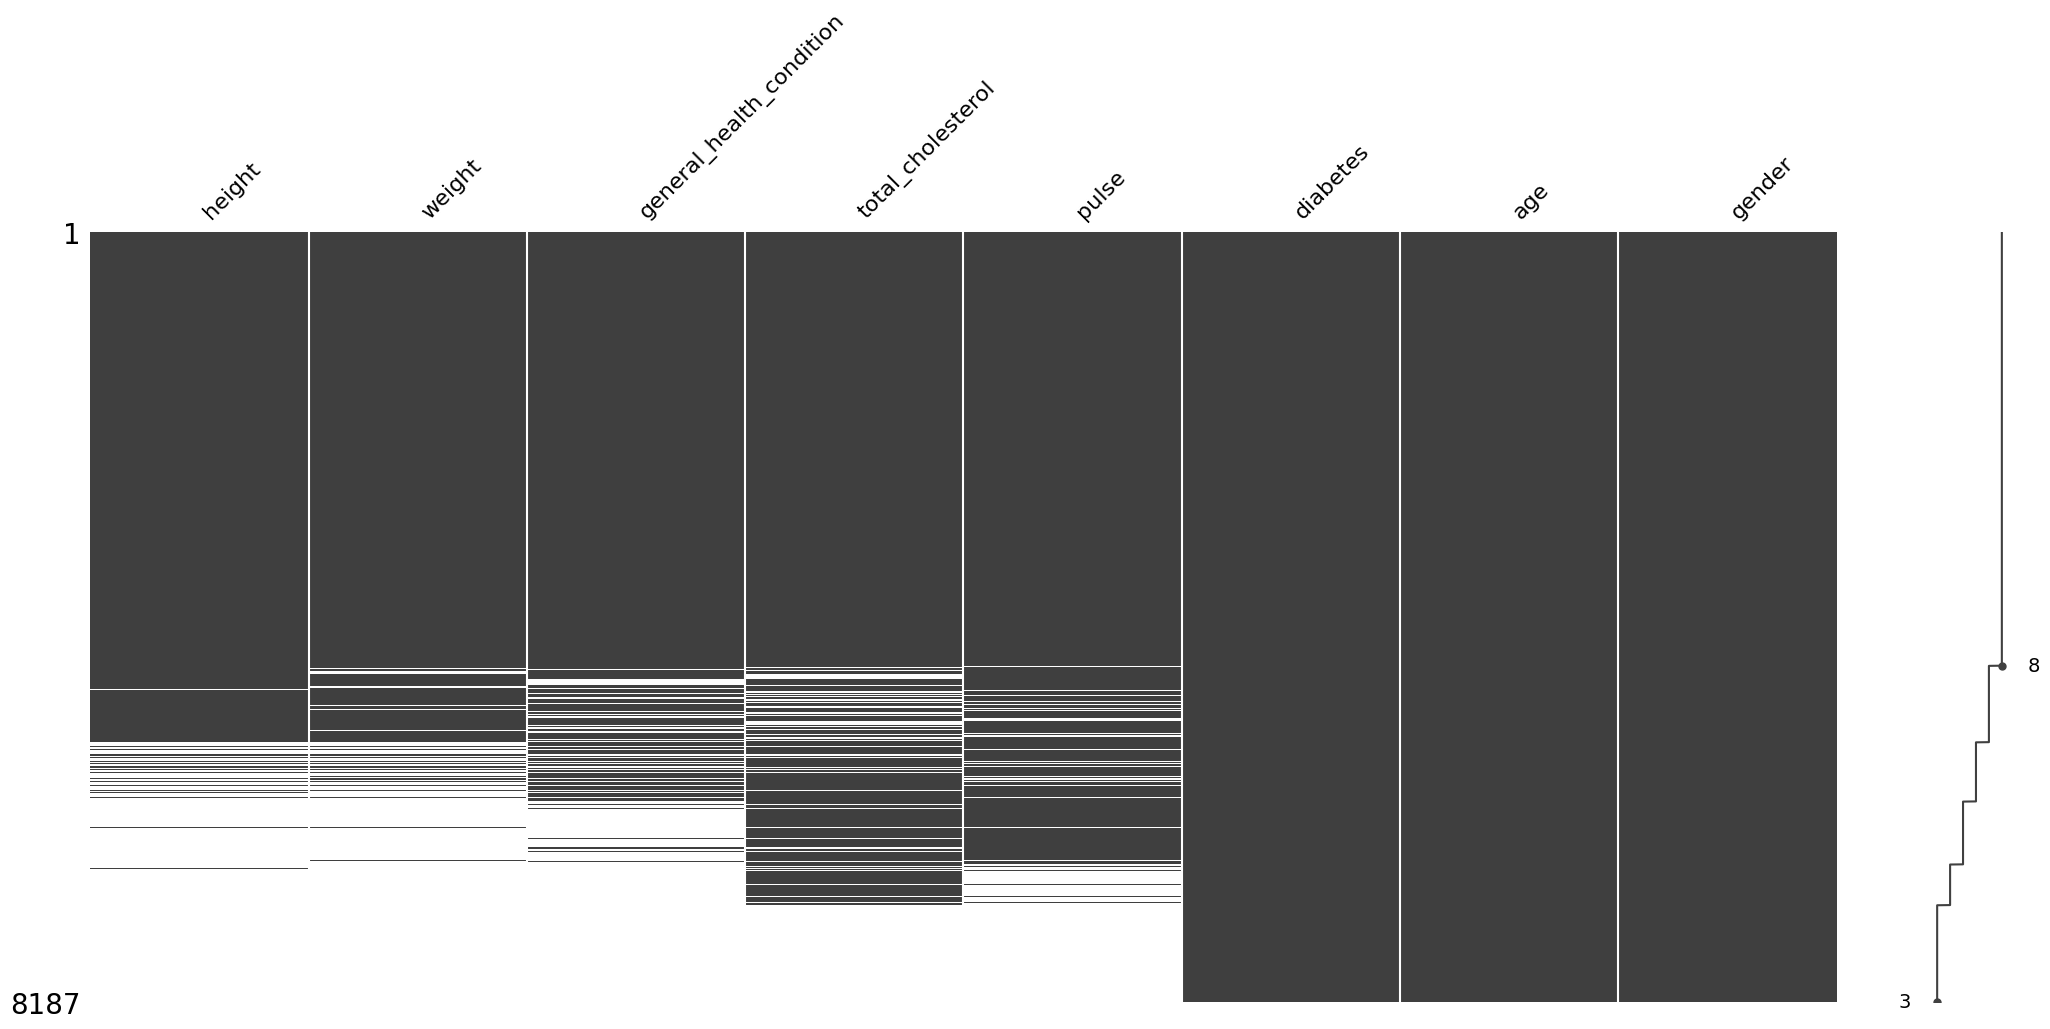

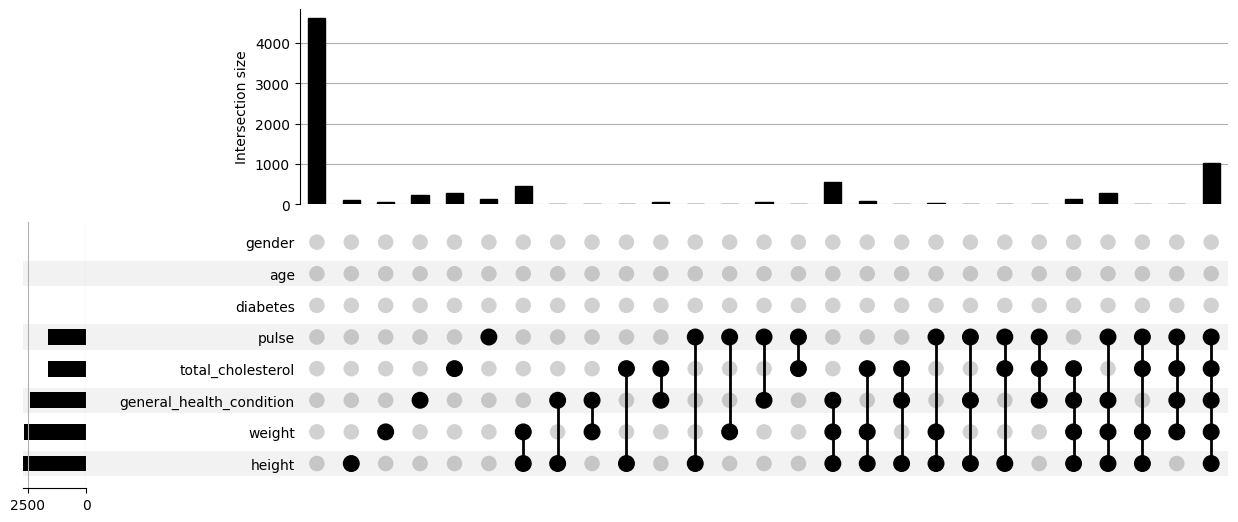

In [8]:
%run download-data-and-load-it.py

## Consideración y evaluación de los distintos tipos de valores faltantes

![Missing data action](./missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    <ul>
        <li><code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.
        </li>
        <li><code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
        <li><code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
    </ul>
    </p>
</div>

In [14]:
# Obtener el peso de las mujeres y los hombres del DataFrame nhanes_df
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")  # Seleccionar las columnas "gender" y "weight" del DataFrame nhanes_df
    .transform_column("weight", lambda x: x.isna(), elementwise=False)  # Transformar la columna "weight" reemplazando los valores NaN por True
    .groupby("gender")  # Agrupar por la columna "gender"
    .weight  # Seleccionar la columna "weight"
    .pipe(lambda df: (df.get_group("Female"), df.get_group("Male")))  # Obtener los grupos de mujeres y hombres
)

# Realizar una prueba t de dos muestras independientes
result = stats.ttest_ind(
    a=female_weight,  # Muestras de peso de las mujeres
    b=male_weight,  # Muestras de peso de los hombres
    alternative="two-sided"  # Realizar una prueba bilateral
)
result

Ttest_indResult(statistic=-0.7659832227497865, pvalue=0.443708373452089)

## Amplía tu conjunto de herramientas para explorar valores faltantes

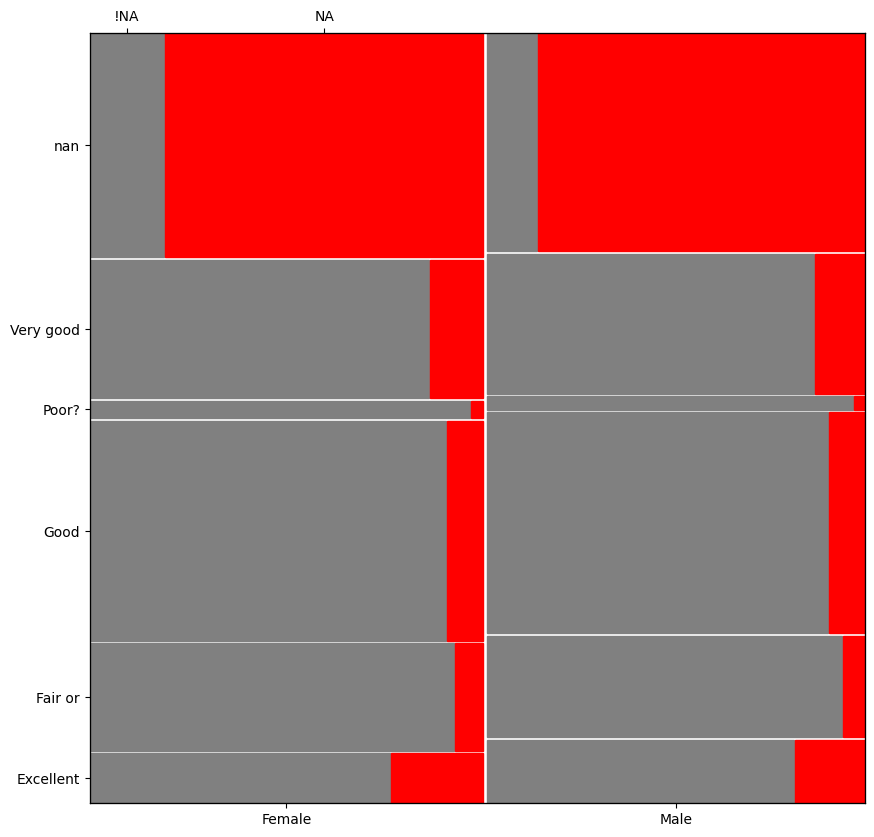

In [15]:
# Crear una figura y ejes para el gráfico de mosaico
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df.select_columns("weight", "general_health_condition", "gender")  # Seleccionar columnas relevantes del DataFrame nhanes_df
    .assign(weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]))  # Asignar etiquetas "NA" y "!NA" a la columna de peso basado en valores NaN
    .groupby(["gender", "general_health_condition", "weight"], dropna=False, as_index=True)  # Agrupar por género, condición de salud general y peso
    .size()  # Obtener el tamaño de cada grupo
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color": "r" if "NA" in key else "gray"},  # Asignar color rojo a los valores "NA" y gris a los demás
            ax=ax,
            horizontal=True,  # Mostrar el gráfico en orientación horizontal
            axes_label=True,  # Mostrar etiquetas de los ejes
            title="",  # Sin título
            labelizer=lambda key: "",  # Sin etiquetas de datos
        )
    )
)

ax.grid(False)  # Desactivar las líneas de cuadrícula en el gráfico

In [18]:
nhanes_df.missing.missing_mosaic_plot("weight", "general_health_condition", "gender")

NameError: name 'mosaic' is not defined

In [19]:
(
    nhanes_df
    .missing  # Acceder al atributo "missing" del DataFrame nhanes_df, que contiene información sobre los valores faltantes
    #.missing_mosaic_plot()  # Llamar al método "missing_mosaic_plot()" para generar el gráfico de mosaico de valores faltantes
)

## Tratamiento de variables categóricas para imputación de valores faltantes

In [20]:
nhanes_transformed_df = nhanes_df.copy(deep=True)  # Se realiza una copia profunda del DataFrame nhanes_df y se asigna a la variable nhanes_transformed_df

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>

    LabelEncoder
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [21]:
# Crear una instancia de OrdinalEncoder
encoder = sklearn.preprocessing.OrdinalEncoder()

# Crear una lista de observaciones
X = [["Male"], ["Female"], ["Female"]]

In [22]:
# Ajustar el codificador a los datos
encoder.fit_transform(X)

# Obtener las categorías asignadas a cada característica
categories = encoder.categories_
categories

[array(['Female', 'Male'], dtype=object)]

In [23]:
# Realizar la transformación inversa
decoded = encoder.inverse_transform([[1], [0], [0]])

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [24]:
# Seleccionar columnas categóricas y se almacena en variable para utilizar como filtro
categorical_columns = nhanes_df.select_dtypes(object).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [25]:
# Crear un transformador de columnas
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),  # Utilizar OrdinalEncoder en las columnas categóricas
    remainder="passthrough"  # Pasar las columnas restantes sin cambios
)
categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [26]:

# Crear un nuevo DataFrame transformado
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),  # Aplicar el transformador a nhanes_df
        columns=categorical_transformer.get_feature_names_out(),  # Obtener los nombres de las columnas transformadas
        index=nhanes_df.index  # Mantener los índices originales de nhanes_df
    )
    .rename_columns(
        function=lambda x: x.removeprefix("ordinalencoder__")  # Eliminar el prefijo "ordinalencoder__" de los nombres de columna
    )
    .rename_columns(
        function=lambda x: x.removeprefix("onehotencoder__")  # Eliminar el prefijo "onehotencoder__" de los nombres de columna
    )
    .rename_columns(
        function=lambda x: x.removeprefix("remainder__")  # Eliminar el prefijo "remainder__" de los nombres de columna
    )
)

# Imprimir el DataFrame transformado
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [21]:
# gender_encoder = sklearn.preprocessing.OrdinalEncoder()

# gender_values = (
#     nhanes_df
#     .gender
#     .values
#     .reshape(-1, 1)
# )

# (
#     gender_encoder
#     .fit_transform(
#         X = gender_values
#     )
#     .squeeze()
# )

# (
#     nhanes_df.gender.unique(),
#     nhanes_transformed_df.gender.unique(),
#     gender_encoder.categories_
# )

### _One Hot Encoding_

In [27]:
#hace una ciopia del dataframe nhanes
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [28]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")  # Seleccionar la columna "general_health_condition" del DataFrame nhanes_transformed_df2
    # .head(10)  # Opcional: Mostrar las primeras 10 filas de la columna seleccionada
    .pipe(pd.get_dummies)  # Aplicar el método get_dummies() de pandas para realizar la codificación one-hot
    # .columns  # Opcional: Mostrar los nombres de las columnas resultantes
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93703.0,0,0,0,0,0
93704.0,0,0,0,0,0
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
...,...,...,...,...,...
102951.0,0,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


#### `skelearn.preprocessing.OneHotEncoder()`

In [29]:
# Crear un transformador de columnas
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),  # Aplicar OrdinalEncoder a la columna "gender"
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),  # Aplicar OneHotEncoder a la columna "general_health_condition"
    remainder="passthrough"  # Pasar las columnas restantes sin cambios
)

In [30]:
# Crear un nuevo DataFrame transformado
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),  # Aplicar el transformador a nhanes_df
        columns=transformer.get_feature_names_out(),  # Obtener los nombres de las columnas transformadas
        index=nhanes_df.index  # Mantener los índices originales de nhanes_df
    )
    .rename_columns(
        function=lambda x: x.removeprefix("ordinalencoder__")  # Eliminar el prefijo "ordinalencoder__" de los nombres de columna
    )
    .rename_columns(
        function=lambda x: x.removeprefix("onehotencoder__")  # Eliminar el prefijo "onehotencoder__" de los nombres de columna
    )
    .rename_columns(
        function=lambda x: x.removeprefix("remainder__")  # Eliminar el prefijo "remainder__" de los nombres de columna
    )
)

nhanes_transformed_df2

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93703.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102951.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [31]:
(
    transformer  # El transformador de columnas
    .named_transformers_  # Diccionario que contiene los transformadores y sus nombres
    .get("onehotencoder")  # Obtener el transformador OneHotEncoder utilizando su nombre
    .categories_  # Acceder a las categorías generadas por el OneHotEncoder
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [32]:
(
    transformer  # El transformador de columnas
    .named_transformers_  # Diccionario que contiene los transformadores y sus nombres
    .get("onehotencoder")  # Obtener el transformador OneHotEncoder utilizando su nombre
    .inverse_transform(  # Utilizar el método inverse_transform() del OneHotEncoder
        X=[[0, 0, 1, 0, 0, 0]]  # Los valores codificados one-hot que deseas revertir
    )
)


array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

![Imputation types](./imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

1. Imputacion por Media, Mediana o Moda

*   Ventajas:
Rapido y facil de implementar.
La media puede ser util en presencia de outliers.
No afectara el estadistico en cuestion ni el tamano de la muestra.

*   Desventajas:
Puede sesgar los resultados, dado que modifica la distribucion por debajo (curtosis). Zona donde se estan aglomerando los datos
Pierdes correlaciones entre variables dado que no es muy preciso o muy real. Carece de variabilidad.
No puedes usarlo en variables categoricas (a excepcion de la moda ya que puedes usar el valor mas frecuente).

In [33]:
(
    nhanes_df
    #Se aplica el transformador a la columna height
    .transform_column(
        "height",
        #Se remplazaran cada uno de los valores faltantes de la columna con la media de la misma
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
    #Muestra la media de la columna transformada
    .height
    .mean()
)

66.25655976676384

In [37]:
#En resumen, este bloque de código crea un gráfico de dispersión de los datos de altura y peso del DataFrame nhanes_df, después de haber realizado la 
# imputación de valores faltantes en esas columnas mediante el reemplazo de los valores faltantes con el promedio de los valores no faltantes en cada 
# columna.

plt.figure(figsize=(10, 10))
suffix = "_imp"
(
    nhanes_df
    #Se seleccionan las columnas "height" y "weight"
    .select_columns("height", "weight")
    #Se le pasa los parametros al metodo bind_shadow_matrix
    .missing.bind_shadow_matrix(suffix : suffix)
    .assign(
        # 
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)


SyntaxError: invalid syntax (3908352896.py, line 12)

In [38]:
(
    nhanes_df.select_columns("height", "weight")
    # Selecciona las columnas "height" y "weight" del DataFrame 'nhanes_df' utilizando el método 'select_columns()'.

    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    # Crea una matriz sombra que registra los valores faltantes en las columnas seleccionadas. 
    # El primer argumento 'True' indica que se deben considerar los valores faltantes como sombra, mientras que 
    # el segundo argumento 'False' indica que no se deben considerar los valores existentes como sombra. 
    # El sufijo "_imp" se agrega al final del nombre de las columnas de la matriz sombra.

    .assign(
        height=lambda df: df.height.fillna(value=df.height.mean()),
        weight=lambda df: df.weight.fillna(value=df.weight.mean()),
    )
    # Asigna nuevos valores a las columnas "height" y "weight" utilizando el método 'assign()'. 
    # Los valores faltantes en cada columna se rellenan con la media de los valores existentes en esa columna.

    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
    # Muestra un gráfico de dispersión de imputación. El eje x corresponde a la columna "height" y el eje y corresponde a la columna "weight". 
    # Los valores faltantes se imputan utilizando la media de cada columna. 
    # Los argumentos 'show_marginal=True' indican que se deben mostrar distribuciones marginales en los ejes x e y, y 
    # 'height=10' ajusta la altura del gráfico a 10 unidades.
)



TypeError: MissingMethods.create_shadow_matrix() got an unexpected keyword argument 'suffix'

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

In [39]:
(
    nhanes_df
    .select_columns("height", "weight")
    # .fillna(method = "ffill")
    .ffill()
)

,height,weight
SEQN,,
93703.0,NaN,NaN
93704.0,NaN,NaN
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
...,...,...
102951.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [40]:
(
    nhanes_df
    .select_columns("height", "weight")
    # .fillna(method = "bfill")
    .bfill()
)

,height,weight
SEQN,,
93703.0,63.0,165.0
93704.0,63.0,165.0
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
...,...,...
102951.0,65.0,218.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [41]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    # Selecciona las columnas "height", "weight", "gender", "diabetes" y "general_health_condition" del DataFrame 'nhanes_df' 
    # utilizando el método 'select_columns()'.

    .sort_values(
        by=["gender", "diabetes", "general_health_condition", "height"],
        ascending=True
    )
    # Ordena el DataFrame seleccionado en función de las columnas "gender", "diabetes", "general_health_condition" y "height". 
    # El argumento 'ascending=True' indica que se debe hacer en orden ascendente.

    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise=False
    )
    # Realiza una transformación en la columna "weight" utilizando el método 'transform_column()'. 
    # En este caso, se utiliza la función 'ffill()' para propagar hacia adelante los valores faltantes en la columna "weight".

)


,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,56.0,115.0,Female,0,Excellent
94187.0,59.0,130.0,Female,0,Excellent
95289.0,59.0,162.0,Female,0,Excellent
97967.0,59.0,130.0,Female,0,Excellent
99125.0,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96954.0,NaN,175.0,Male,1,NaN
97267.0,NaN,175.0,Male,1,NaN


## Imputación por interpolación

<Axes: xlabel='date'>

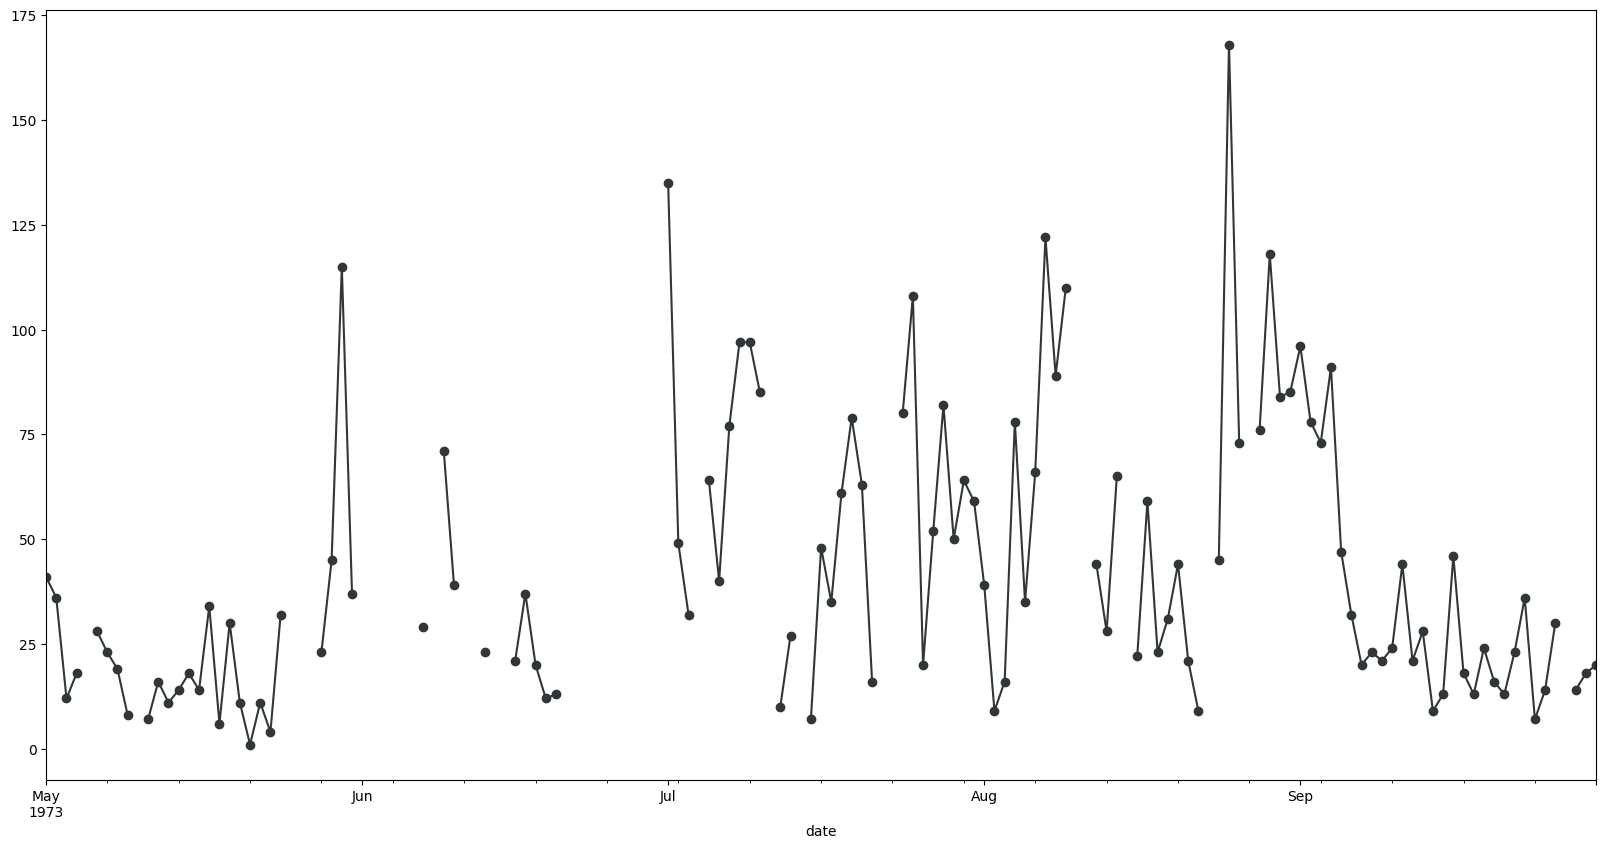

In [42]:
plt.figure(figsize=(20, 10))
# Crea una nueva figura con un tamaño de 20 unidades de ancho y 10 unidades de alto utilizando la función 'figure()' de matplotlib.pyplot.

(
    airquality_df
    # Selecciona el DataFrame 'airquality_df'.

    .select_columns("ozone")
    # Selecciona la columna "ozone" del DataFrame utilizando el método 'select_columns()'.

    .pipe(
        lambda df: (
            df.ozone.plot(color="#313638", marker="o")
            # Hace un trazado de la columna "ozone" del DataFrame utilizando el método 'plot()' de pandas. 
            # Los valores completos se representarán mediante líneas negras y se utilizará un marcador circular para cada punto en el trazado.
        )
    )
)


(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

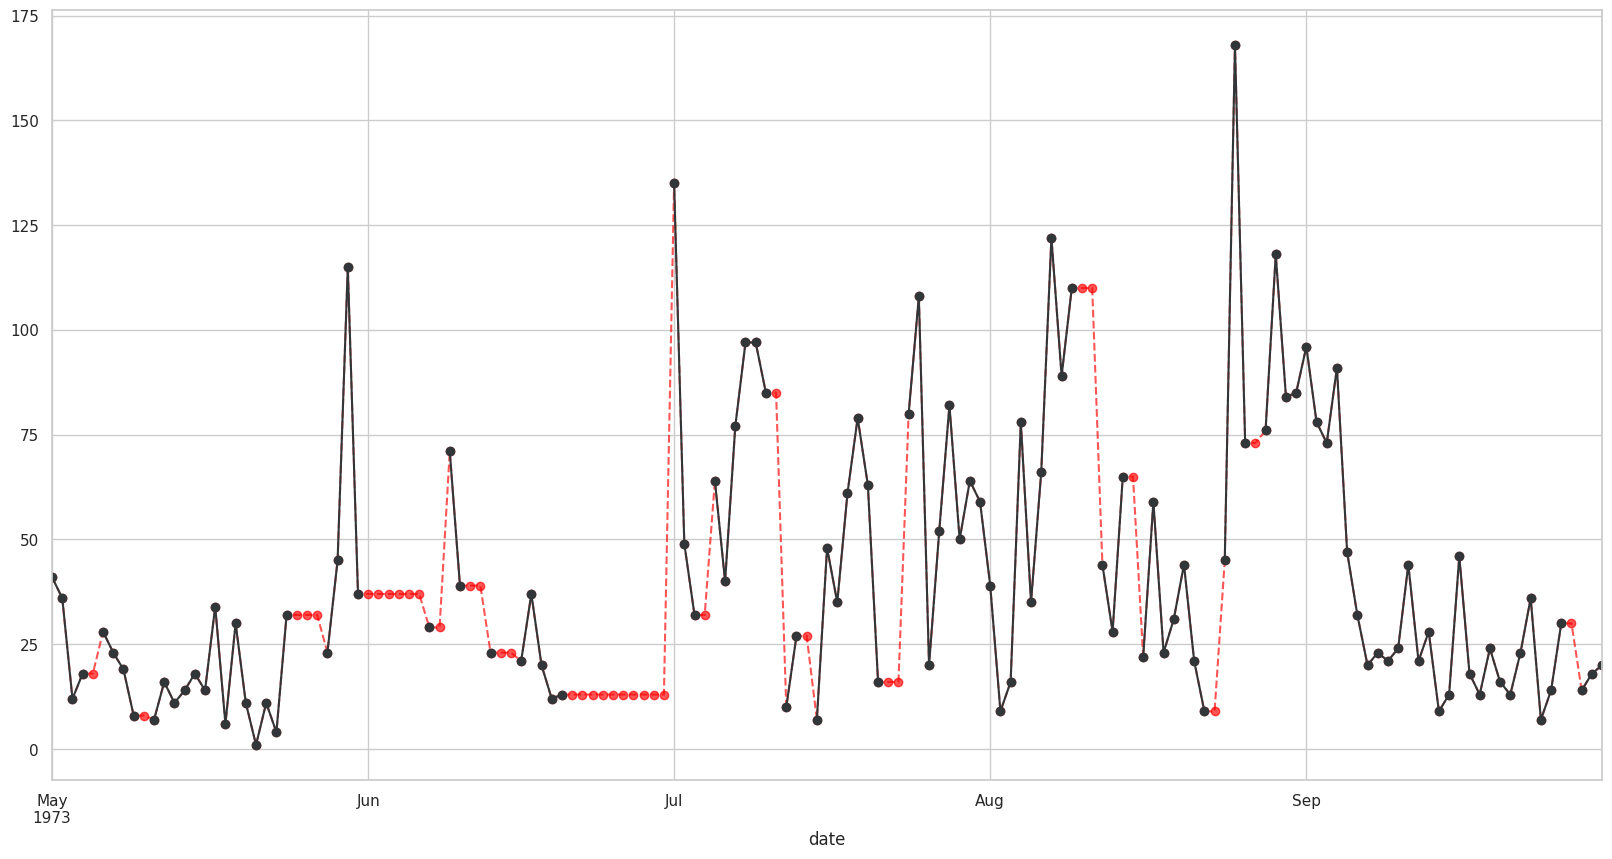

In [35]:
plt.figure(figsize=(20,10))

(
    airquality_df
    #Se utilizara la columna 'ozone'
    .select_columns("ozone")
    .pipe(
        lambda df: (
            #Los colores de los elementos faltantes seran 'rojo'
            df.ozone.ffill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            #Los colores de las lineas de valores completos eran negros
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

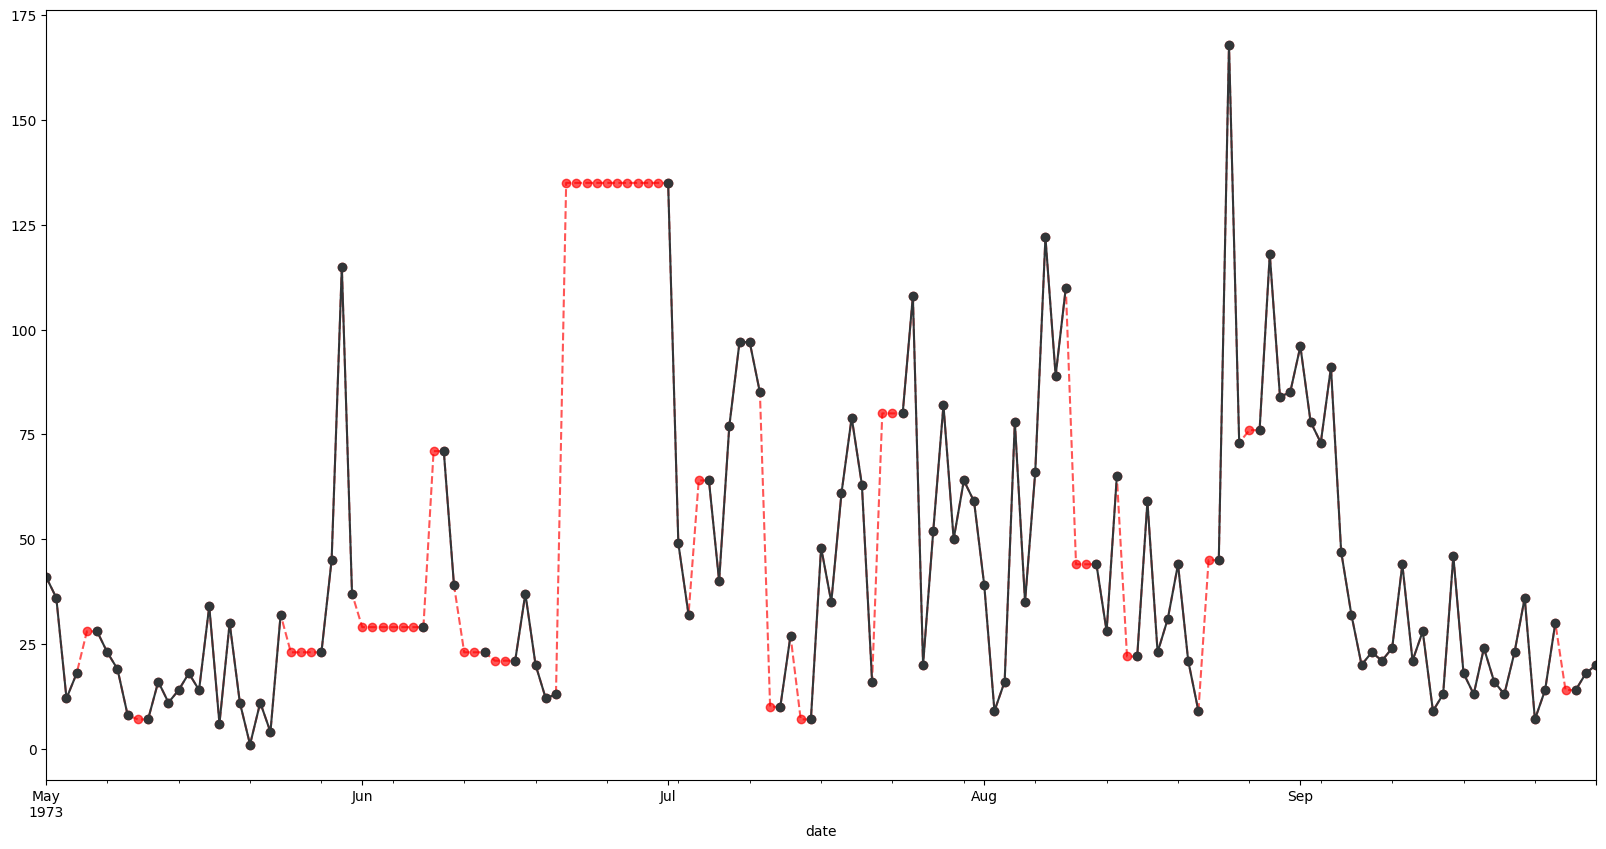

In [43]:
plt.figure(figsize=(20,10))

(
    airquality_df
    #Se seleccionara la columna 'ozone'
    .select_columns("ozone")
    .pipe(
        lambda df: (
            #rellena los valores faltantes en la columna 'ozone' utilizando el método bfill o remplzar los valores por el valor siguiente
            df.ozone.bfill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            #Traza una linea con los valores disponibles
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

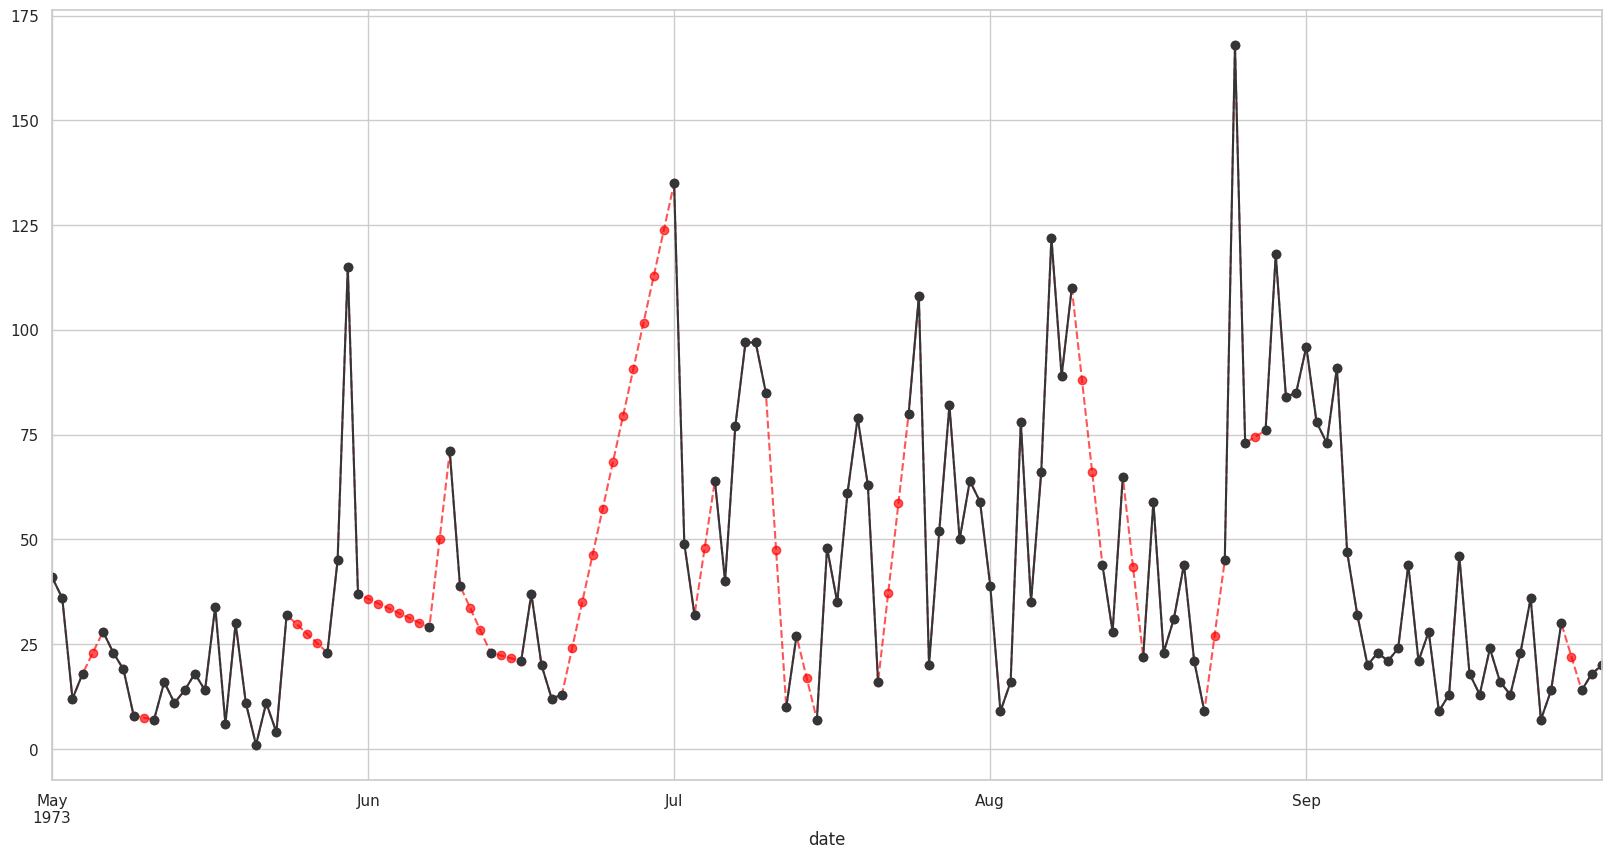

In [37]:
plt.figure(figsize=(20,10))

(
    airquality_df
    #Se selecciona la columna 'ozone'
    .select_columns("ozone")
    .pipe(
        lambda df: (
            # realiza una interpolación lineal utilizando el método "linear" para rellenar los valores faltantes en la columna 'ozone' del DataFrame.
            df.ozone.interpolate(method = "linear").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            #Crea un grafico con los valores disponibles representado por el color gris
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

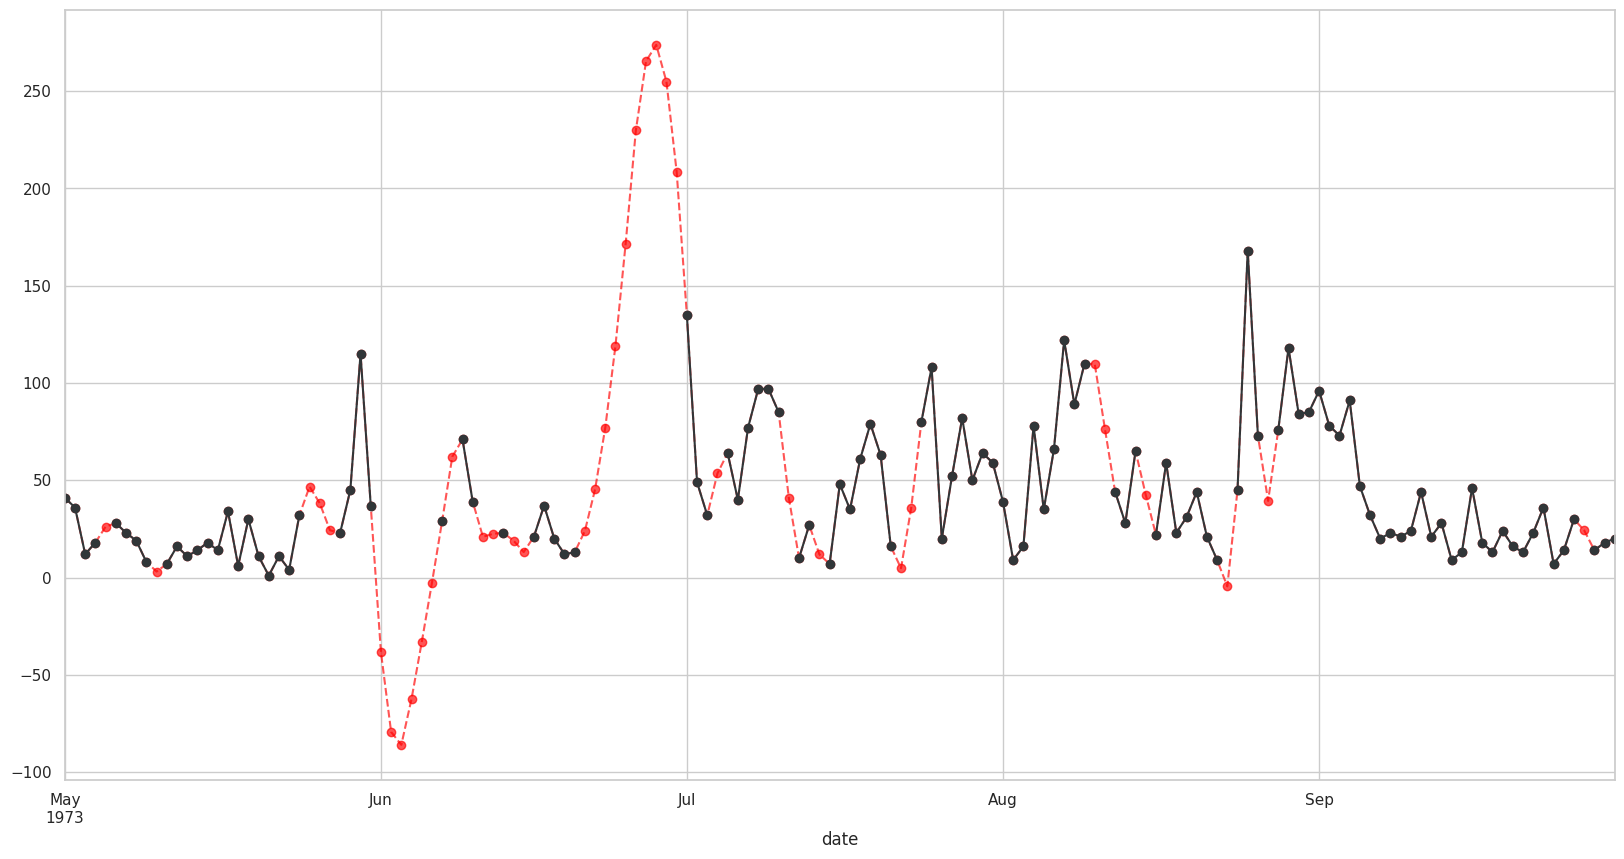

In [38]:
plt.figure(figsize=(20,10))

(
    airquality_df
    #Se selecciona la columna 'Ozone'
    .select_columns("ozone")
    .pipe(
        lambda df: (
            #Se utiliza la interpolacion cuadratica para remplazar los valores faltantes utilizando el color rojo
            df.ozone.interpolate(method = "quadratic").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

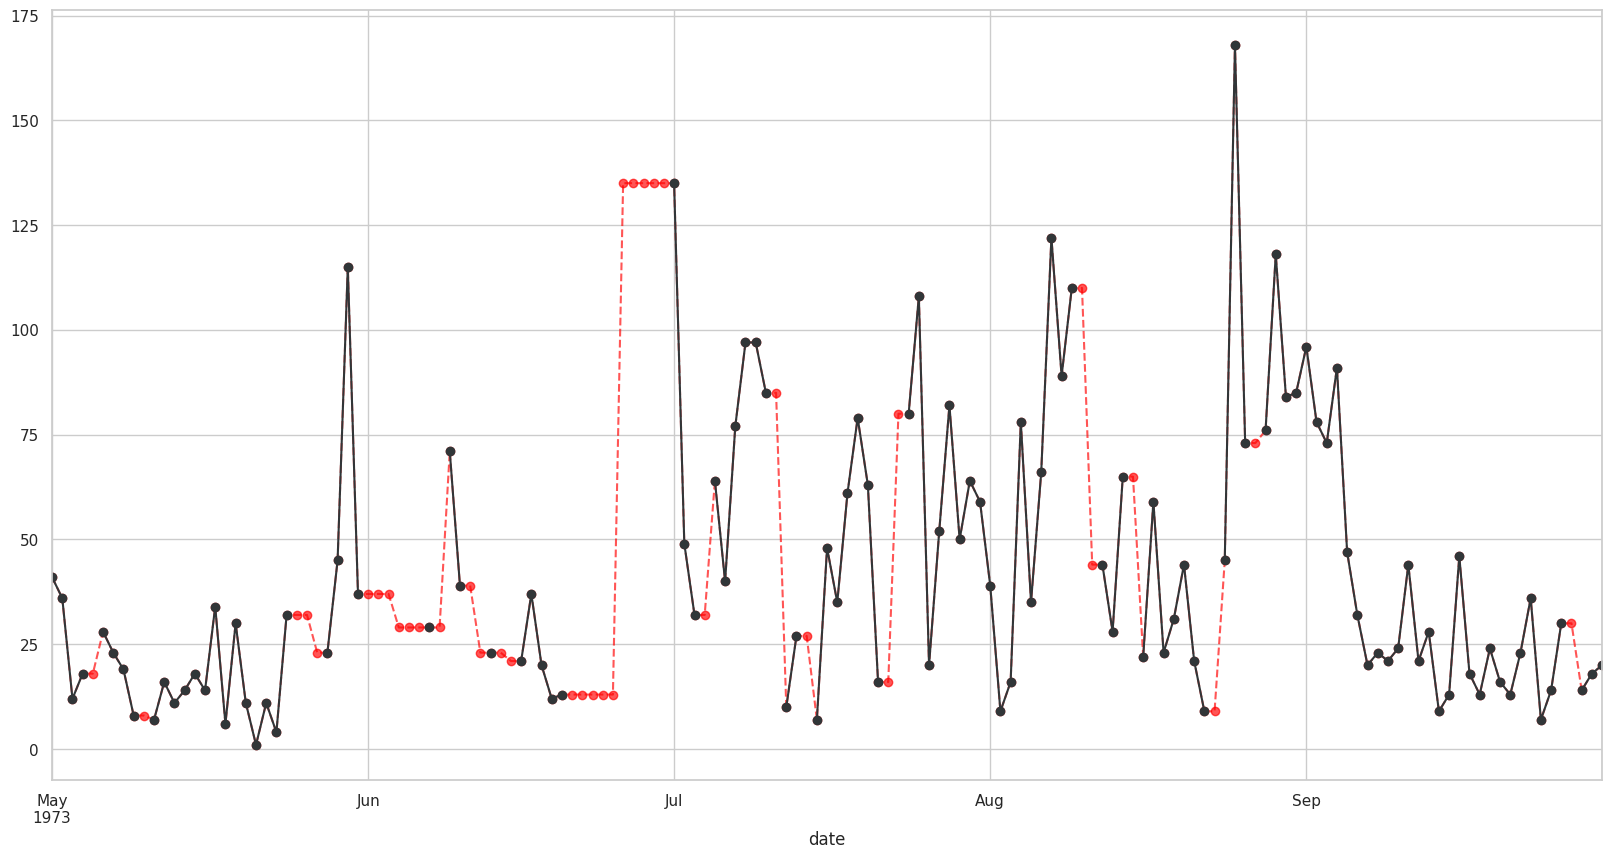

In [39]:
plt.figure(figsize=(20, 10))
# Crea una nueva figura con un tamaño de 20 unidades de ancho y 10 unidades de alto utilizando la función 'figure()' de matplotlib.pyplot.

(
    airquality_df
    # Selecciona el DataFrame 'airquality_df'.

    .select_columns("ozone")
    # Selecciona la columna "ozone" del DataFrame utilizando el método 'select_columns()'.

    .pipe(
        lambda df: (
            df.ozone.interpolate(method="nearest").plot(color="red", marker="o", alpha=6/9, linestyle="dashed"),


## Imputación por algoritmo de vecinos más cercanos (KNN)

Resumen de métodos de distancia:

Euclidiana: Útil para variables numéricas

Manhattan: Útil paa variables tipo factor

Hamming: Útil para variables categóricas

Gower: Útil para conjuntos de datos con variables mixtas

In [44]:
nhanes_df.head()

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male


In [45]:
nhanes_transformed_df.head()

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0


En resumen, este bloque de código utiliza el imputador KNNImputer para imputar los valores faltantes en el DataFrame 'nhanes_transformed_df'. Los valores imputados se redondean y se asignan de vuelta al DataFrame 'nhanes_df_knn'. Finalmente, se muestra el DataFrame 'nhanes_df_knn' que contiene los valores imputados mediante el algoritmo K-Nearest Neighbors.

In [46]:
knn_imputer = sklearn.impute.KNNImputer()
# Se crea una instancia de la clase KNNImputer del módulo sklearn.impute. Esta clase se utiliza para imputar valores faltantes utilizando el algoritmo K-Nearest Neighbors.

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)
# Se crea una copia profunda del DataFrame 'nhanes_transformed_df' y se asigna a la variable 'nhanes_df_knn'. Esto se hace para trabajar con una copia independiente del DataFrame.

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()
# Se aplica el método fit_transform() del imputador KNN al DataFrame 'nhanes_df_knn'. Esto calcula los valores imputados utilizando el algoritmo K-Nearest Neighbors y los reemplaza en el DataFrame. Luego, se redondean los valores imputados.

nhanes_df_knn
# Se muestra el DataFrame 'nhanes_df_knn' que contiene los valores imputados mediante K-Nearest Neighbors.


,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,2.0,0.0,63.0,137.0,151.0,91.0,0.0,2.0
93704.0,2.0,1.0,71.0,152.0,164.0,86.0,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,2.0,1.0,71.0,152.0,164.0,86.0,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


En resumen, este bloque de código concatena el DataFrame nhanes_df_knn con una matriz sombra que registra los valores faltantes en nhanes_df. Luego, se utiliza el DataFrame resultante para generar un gráfico de dispersión de imputación, donde se comparan los valores imputados de las columnas "height" y "weight".

In [47]:
(
    pd.concat(
        [
            nhanes_df_knn,  # Se concatena el DataFrame nhanes_df_knn
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
            # Se concatena el resultado de crear una matriz sombra que registra los valores faltantes en nhanes_df
            # Los argumentos True y False indican que se crearán columnas sombra para las variables faltantes y no faltantes respectivamente
            # El sufijo "_imp" se agrega al final del nombre de las columnas de la matriz sombra
            # El argumento only_missing=True indica que solo se incluirán columnas con valores faltantes en la matriz sombra
        ],
        axis=1  # Se especifica que la concatenación se realizará a lo largo del eje 1 (columnas)
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
    # Se utiliza el método missing.scatter_imputation_plot() en el DataFrame resultante para generar un gráfico de dispersión de imputación
    # Los valores imputados se utilizan para el trazado
    # Los ejes x e y del gráfico corresponden a las columnas "height" y "weight" respectivamente
)


TypeError: MissingMethods.create_shadow_matrix() got an unexpected keyword argument 'suffix'

### Ordenamiento por cantidad de variables faltantes

En resumen, este bloque de código realiza la imputación de valores faltantes utilizando el algoritmo K-Nearest Neighbors con 10 vecinos más cercanos. Luego, concatena el DataFrame imputado con una matriz sombra que registra los valores faltantes en el DataFrame original y genera un gráfico de dispersión de imputación utilizando las columnas "height" y "weight".

<AxesSubplot:xlabel='height', ylabel='weight'>

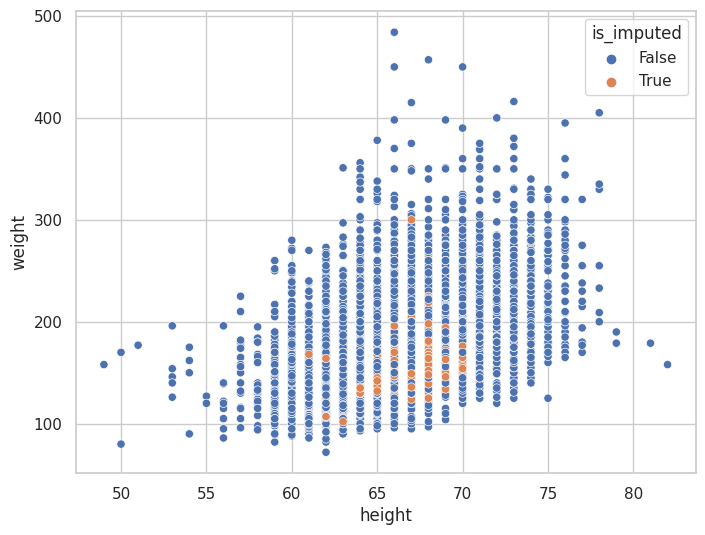

In [44]:
knn_imputer = sklearn.impute.KNNImputer(n_neighbors=10)
# Se crea una instancia de la clase KNNImputer del módulo sklearn.impute. Se especifica que se utilizarán 10 vecinos más cercanos para la imputación.

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)
# Se realiza lo siguiente:
# - Se llama al método missing.sort_variables_by_missingness() en el DataFrame nhanes_transformed_df para ordenar las columnas por su cantidad de valores faltantes en orden ascendente.
# - Se realiza una copia profunda del DataFrame resultante y se asigna a la variable nhanes_df_knn. Esto se hace para trabajar con una copia independiente del DataFrame.

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()
# Se aplica el método fit_transform() del imputador KNN al DataFrame nhanes_df_knn. Esto calcula los valores imputados utilizando el algoritmo K-Nearest Neighbors y los reemplaza en el DataFrame. Luego, se redondean los valores imputados.

(
    pd.concat(
        [
            nhanes_df_knn,  # Se concatena el DataFrame nhanes_df_knn
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
            # Se concatena el resultado de crear una matriz sombra que registra los valores faltantes en nhanes_df
            # Utiliza el método missing.create_shadow_matrix() en nhanes_df.missing
            # Los argumentos True y False indican que se crearán columnas sombra para las variables faltantes y no faltantes respectivamente
            # El sufijo "_imp" se agrega al final del nombre de las columnas de la matriz sombra
            # El argumento only_missing=True indica que solo se incluirán columnas con valores faltantes en la matriz sombra
        ],
        axis=1  # Se especifica que la concatenación se realizará a lo largo del eje 1 (columnas)
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
    # Se utiliza el método missing.scatter_imputation_plot() en el DataFrame resultante para generar un gráfico de dispersión de imputación
    # Los valores imputados se utilizan para el trazado
    # Los ejes x e y del gráfico corresponden a las columnas "height" y "weight" respectivamente
)

)

## Imputación basada en modelos

En resumen, este código prepara el DataFrame nhanes_model_df para su uso en un modelo, realizando la selección de columnas, ordenamiento, transformación y creación de una matriz sombra de valores faltantes.

In [45]:
nhanes_model_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "age")  # Se seleccionan las columnas "height", "weight", "gender" y "age" del DataFrame nhanes_df.
    .sort_values(by="height")  # Se ordena el DataFrame por la columna "height" en orden ascendente.
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise=False
    )  # Se aplica una transformación a la columna "weight" utilizando el método ffill() para rellenar los valores faltantes con los valores anteriores.
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix="_imp"
    )  # Se crea una matriz sombra que registra los valores faltantes en el DataFrame. Se utiliza el método bind_shadow_matrix() con los argumentos True, False y suffix="_imp".
)


nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [46]:
height_ols = (
    nhanes_model_df  # DataFrame utilizado para el ajuste del modelo de regresión
    .pipe(
        lambda df: smf.ols("height ~ weight + gender + age", data=df)
        # Se utiliza el método pipe para pasar el DataFrame a la función lambda,
        # donde se especifica el modelo de regresión utilizando la sintaxis de fórmula de statsmodels.
        # La variable dependiente es "height" y las variables independientes son "weight", "gender" y "age".
    )
    .fit()  # Se ajusta el modelo utilizando el método fit() de statsmodels y se obtienen los resultados de la regresión
)


En resumen, este código utiliza el modelo de regresión height_ols para predecir los valores faltantes de la columna "height" en el DataFrame nhanes_model_df. Los valores predichos se redondean y se asignan a la variable ols_imputed_values.

In [47]:
ols_imputed_values = (
    nhanes_model_df  # DataFrame utilizado para la imputación de valores faltantes
    .pipe(
        lambda df: df[df.height.isna()]
        # Se utiliza el método pipe para pasar el DataFrame a la función lambda,
        # donde se filtran las filas donde la columna "height" tiene valores faltantes (NaN).
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
        # Se utiliza el método pipe para pasar el DataFrame filtrado a la función lambda,
        # donde se utilizan los valores del modelo de regresión `height_ols` para predecir los valores de "height" en las filas filtradas.
        # Los valores predichos se redondean utilizando el método round().
    )
)

ols_imputed_values


SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

En resumen, esta línea de código reemplaza los valores faltantes en la columna "height" del DataFrame nhanes_model_df con los valores imputados obtenidos a partir del modelo de regresión. Esto actualiza el DataFrame con los valores imputados.

In [48]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values

En resumen, este código muestra un gráfico de dispersión que visualiza la relación entre las variables "height" y "weight" en el DataFrame nhanes_model_df, resaltando los valores imputados. Este gráfico ayuda a evaluar la efectividad de la imputación de valores faltantes

<AxesSubplot:xlabel='height', ylabel='weight'>

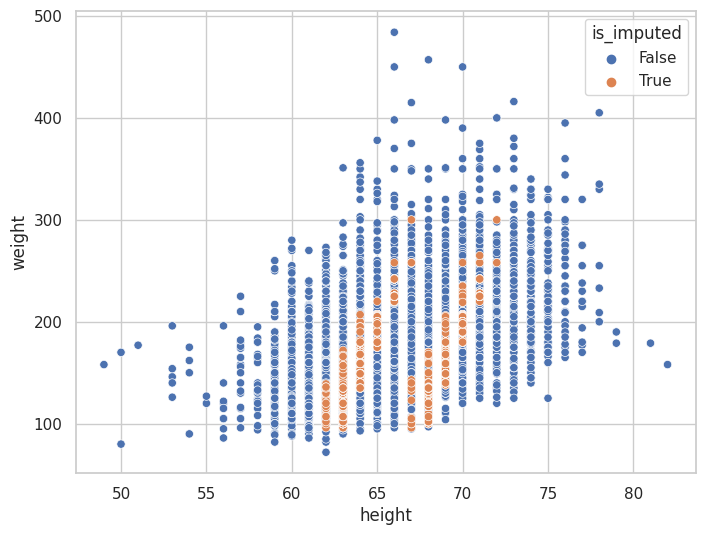

In [49]:
(
    nhanes_model_df  # DataFrame utilizado para la imputación de valores faltantes
    .missing  # Acceso al atributo 'missing' para realizar operaciones relacionadas con valores faltantes
    .scatter_imputation_plot(
        x="height",  # Variable utilizada como eje x en el gráfico de dispersión
        y="weight"  # Variable utilizada como eje y en el gráfico de dispersión
    )
)


## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

En resumen, este código utiliza el método de imputación iterativa (MICE) para manejar los valores faltantes en el DataFrame nhanes_mice_df. Luego, concatena el DataFrame imputado con una matriz sombra creada a partir de nhanes_df, y finalmente, genera un gráfico de dispersión para visualizar la imputación de valores faltantes en las variables "height" y "weight".

<AxesSubplot:xlabel='height', ylabel='weight'>

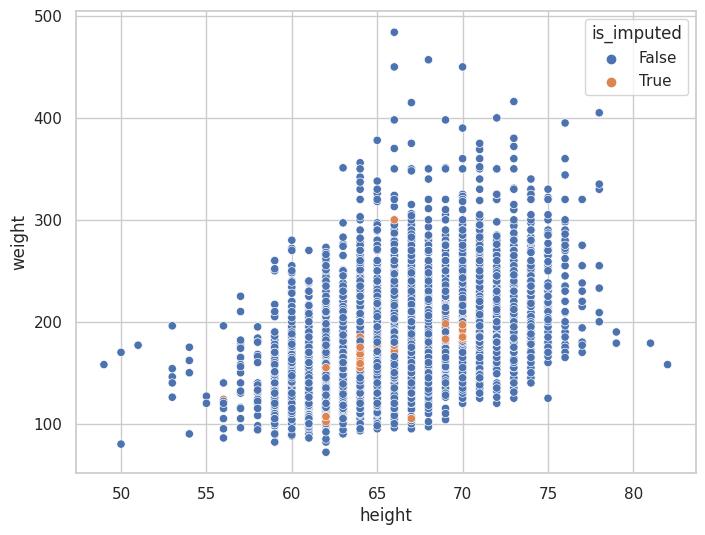

In [50]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())
# Se crea un objeto 'mice_imputer' que utiliza el método de imputación iterativa y se especifica el estimador 'BayesianRidge()' 
# como modelo para la imputación.

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)
# Se realiza una copia profunda del DataFrame 'nhanes_transformed_df' y se asigna a 'nhanes_mice_df'. 
# Esta copia se utilizará para realizar la imputación.

nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_mice_df).round()
# Se aplica el método 'fit_transform()' del objeto 'mice_imputer' para realizar la imputación iterativa en el DataFrame 'nhanes_mice_df'.
# Los valores imputados se asignan nuevamente a 'nhanes_mice_df' y se redondean utilizando el método 'round()'.

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
    ],
    axis=1
)
# Se utiliza 'pd.concat()' para concatenar el DataFrame 'nhanes_mice_df' con la matriz sombra creada a partir de 'nhanes_df'.
# La matriz sombra se crea utilizando el método 'create_shadow_matrix()' del atributo 'missing' de 'nhanes_df',
# y solo se incluyen las columnas correspondientes a los valores faltantes (only_missing=True).
# Se agrega el sufijo "_imp" a las columnas de la matriz sombra creada.
# El resultado se asigna nuevamente a 'nhanes_mice_df'.

nhanes_mice_df.missing.scatter_imputation_plot(
    x="height",
    y="weight"
)
# Se utiliza el método 'scatter_imputation_plot()' del atributo 'missing' de 'nhanes_mice_df' para generar un gráfico de dispersión 
# que visualiza la imputación de valores faltantes.
# Se especifica "height" como el eje x del gráfico y "weight" como el eje y.


### Transformación inversa de los datos

En resumen, este código crea una copia del DataFrame 'nhanes_mice_df' llamada 'nhanes_imputated_df' y realiza la transformación inversa de las variables categóricas imputadas utilizando el objeto 'categorical_transformer'. Los valores transformados se asignan a las columnas correspondientes en 'nhanes_imputated_df'. El resultado es el DataFrame 'nhanes_imputated_df' que contiene los datos imputados y las variables categóricas invertidas.

In [51]:
nhanes_imputated_df = nhanes_mice_df.copy(deep=True)
# Se realiza una copia profunda del DataFrame 'nhanes_mice_df' y se asigna a 'nhanes_imputated_df'. Esta copia se utilizará para almacenar los datos imputados.

nhanes_imputated_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)
# Se utiliza el objeto 'categorical_transformer' para realizar la transformación inversa de las variables categóricas imputadas.
# Se accede al transformador 'ordinalencoder' dentro del objeto 'categorical_transformer'.
# Luego, se utiliza el método 'inverse_transform()' para invertir la transformación en las columnas categóricas seleccionadas ('categorical_columns')
# utilizando los datos imputados del DataFrame 'nhanes_mice_df'.
# Los valores transformados se asignan a las columnas correspondientes en el DataFrame 'nhanes_imputated_df'.

nhanes_imputated_df
# Se devuelve el DataFrame 'nhanes_imputated_df', que contiene los datos imputados y las variables categóricas invertidas.


,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp
SEQN,,,,,,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0,True,True,False,False,False
93709.0,Good,Female,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False
93711.0,Very good,Male,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False
102954.0,Good,Female,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False


In [52]:
#Cuenta a cantidad de valores de la columna general_healt_condition
nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [53]:
#Cuenta a cantidad de valores de la columna general_healt_condition
nhanes_imputated_df.general_health_condition.value_counts()

Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [54]:
#Cuenta la cantidad de valores faltantes
nhanes_mice_df.missing.number_missing()

0

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <br>
    <br>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    <br>
    <br>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    <br>
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [55]:
session_info.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>